In [442]:
import cv2, os
import matplotlib.pyplot as plt 
import argparse as ap
import cv2
import numpy as np
import os
from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn.externals import joblib
from scipy.cluster.vq import *
from sklearn.preprocessing import StandardScaler

In [443]:
def imlist(path):
    """
    The function imlist returns all the names of the files in 
    the directory path supplied as argument to the function.
    """
    return [os.path.join(path, f) for f in os.listdir(path) if f.__contains__(".jpg")]

def imshow(im_title, im, poi):
    ''' This is function to display the image'''
    plt.figure()  
    plt.title(im_title)
    plt.axis("off")
    if len(im.shape) == 2:
        plt.imshow(im, cmap = "gray")
    else:
        im_display = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
        plt.imshow(im_display)
    if poi is not None:
        for point in poi:
            plt.scatter(point[0], point[1])
    plt.show()

def imreads(path):
    '''
    This reads all the images in a given folder and returns the results 
    '''
    images_path = imlist("/home/bikz05/Desktop/back_projection")
    images = []
    for image_path in images_path:
        images.append(cv2.imread(image_path, cv2.CV_LOAD_IMAGE_COLOR))
    return images

In [444]:
# Get the training classes names and store them in a list
train_path = "./train"
test_path = "./test"
training_names = os.listdir("train")

# Get all the path to the images and save them in a list
# image_paths and the corresponding label in image_paths
image_paths = []
image_classes = []
class_id = 0
for training_name in training_names:
    dir = os.path.join(train_path, training_name)
    class_path = imlist(dir)
    image_paths+=class_path
    image_classes+=[class_id]*len(class_path)
    class_id+=1

In [445]:

# Create feature extraction and keypoint detector objects
fea_det = cv2.xfeatures2d.SIFT_create()
#des_ext = cv2.DescriptorExtractor_create("SIFT")

def extract_and_scale_features(image_paths, show_image=False):
    # List where all the descriptors are stored
    des_list = []
    
    for image_path in image_paths:
        im = cv2.imread(image_path)
        kpts, des = fea_det.detectAndCompute(im, None)
        if show_image:
            imshow(image_path, im, [point.pt for point in kpts])
        des_list.append((image_path, des))   

    # Stack all the descriptors vertically in a numpy array
    descriptors = des_list[0][1]
    for image_path, descriptor in des_list[1:]:
        descriptors = np.vstack((descriptors, descriptor))  

    # Perform k-means clustering
    k = 100
    voc, variance = kmeans(descriptors, k, 1) 

    # Calculate the histogram of features
    im_features = np.zeros((len(image_paths), k), "float32")
    for i in range(len(image_paths)):
        words, distance = vq(des_list[i][1],voc)
        for w in words:
            im_features[i][w] += 1

    # Perform Tf-Idf vectorization
    nbr_occurences = np.sum( (im_features > 0) * 1, axis = 0)
    idf = np.array(np.log((1.0*len(image_paths)+1) / (1.0*nbr_occurences + 1)), 'float32')

    # Scaling the words
    stdSlr = StandardScaler().fit(im_features)
    im_features = stdSlr.transform(im_features)
    
    return im_features


In [446]:
im_features = extract_and_scale_features(image_paths)

# Train the Linear SVM
clf = LinearSVC()
clf.fit(im_features, np.array(image_classes))  


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [447]:
clf, classes_names, stdSlr, k, voc = clf, training_names, stdSlr, k, voc
training_names = os.listdir("test")[1:]

# Get all the path to the images and save them in a list
# image_paths and the corresponding label in image_paths
image_paths = []
image_classes = []
class_id = 0
for training_name in training_names:
    dir = os.path.join(test_path, training_name)
    class_path = imlist(dir)
    image_paths+=class_path
    image_classes+=[class_id]*len(class_path)
    class_id+=1


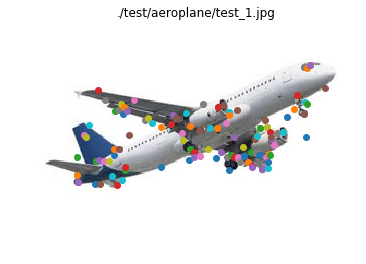

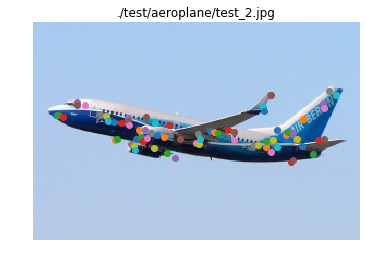

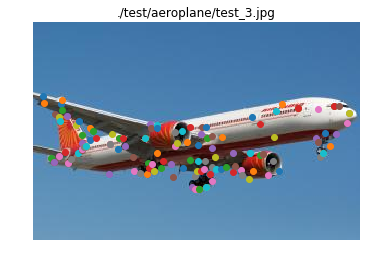

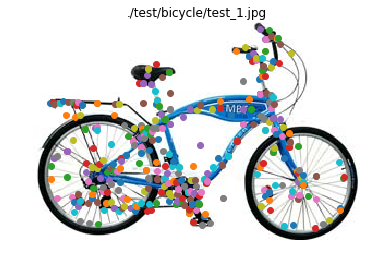

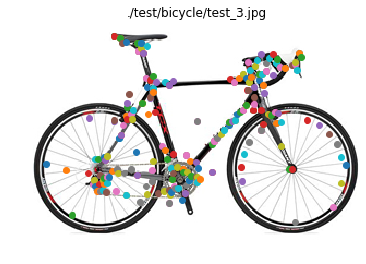

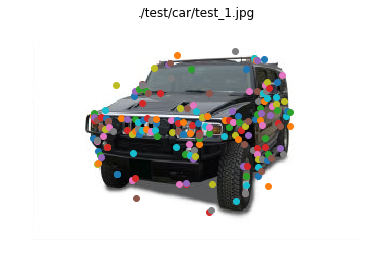

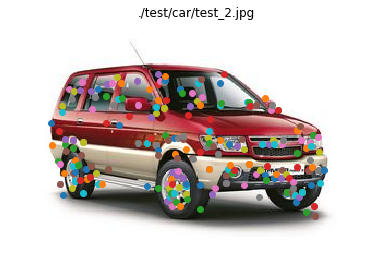

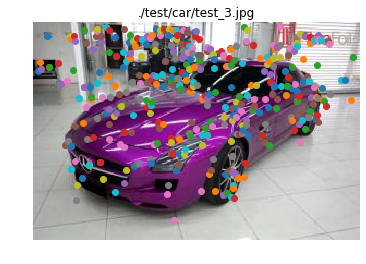

[('./test/aeroplane/test_1.jpg', 'aeroplane'),
 ('./test/aeroplane/test_2.jpg', 'aeroplane'),
 ('./test/aeroplane/test_3.jpg', 'aeroplane'),
 ('./test/bicycle/test_1.jpg', 'car'),
 ('./test/bicycle/test_3.jpg', 'car'),
 ('./test/car/test_1.jpg', 'bicycle'),
 ('./test/car/test_2.jpg', 'car'),
 ('./test/car/test_3.jpg', 'car')]

In [436]:
test_features = extract_and_scale_features(image_paths, True)
prediction_results = clf.predict(test_features);
[(image_paths[i], classes_names[prediction_results[i]]) for i in range(len(prediction_results))]